# Titanic Survivability Analysis using Various Classifiers

In [37]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn import datasets,svm,model_selection,tree,preprocessing,metrics
import sklearn.ensemble as ske
import tensorflow as tf

## Importing dataset and Basic Analytics

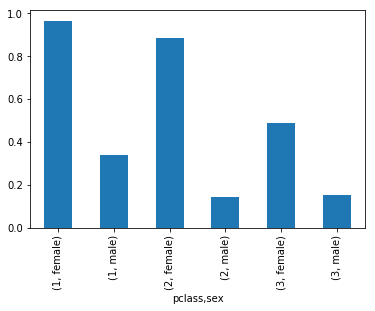

0.381970970206
        survived        age     sibsp     parch       fare        body
pclass                                                                
1       0.619195  39.159918  0.436533  0.365325  87.508992  162.828571
2       0.429603  29.506705  0.393502  0.368231  21.179196  167.387097
3       0.255289  24.816367  0.568406  0.400564  13.302889  155.818182
               survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.85416

In [38]:
# Dataset import into pandas dataframe
titanic_df = pd.read_excel('titanic3.xls','titanic3',index_col=None,na_values=['NA'])
#print(titanic_df.head())

# Scatter Plot - pretty much all women in first class survived
class_sex_grouping['survived'].plot.bar()
plt.show()

# Show means of features(columns) by class
print(titanic_df['survived'].mean())
print(titanic_df.groupby('pclass').mean())

# Class-sex grouping
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
print(class_sex_grouping)



## Preprocessing

In [39]:
# Preprocessing

def preprocess(df):
	processed_df = df.copy()
	# LabelEncoder converts categorical strings
	# such as Male and Female to integers
	# for make it easier to process 
	le = preprocessing.LabelEncoder()
	processed_df.sex = le.fit_transform(processed_df.sex)
	processed_df.embarked = le.fit_transform(processed_df.embarked)
	# Since Name, Ticket and Destination are not class
	# Labels we drop them too.
	processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
	return processed_df

# Discovering bad features for classification

We cannot preprocess data which has missing values or NaNs in them. Here, we drop features which aren't very good for classification and clean the remaining data before preprocessing

In [40]:
# Print out no. of NaNs in each feature(column)
print(titanic_df.isnull().sum())

# Since 'body', 'cabin' and 'boat' have a large number of NaNs, drop them
titanic_df = titanic_df.drop(['body','cabin','boat'],axis=1)

# To drop NaN fields in kept features, first find all those NaNs and fill them as "NA"
titanic_df['home.dest'] = titanic_df['home.dest'].fillna("NA")
# Next, use df.dropna() to drop all fields with NA in them automatically.
titanic_df = titanic_df.dropna()

processed_df=preprocess(titanic_df) # Okay, preprocess cleaned data

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


## Generate Training and Testing data

In [41]:
# X is data; contains all features other than 'survived' (make X by dropping 'survived' column alone)
X = processed_df.drop(['survived'],axis=1).values

# Y is class label: Yes or No. (make Y by only keeping the 'survived' column) 
Y = processed_df['survived'].values

## Creating Classifiers

In [42]:
# Simple Decision Tree Classifier
simpleclf = tree.DecisionTreeClassifier(max_depth=10)

# Random Forest Classifier
rfclf = ske.RandomForestClassifier()

# Gradient Boosting Classifier
gbclf = ske.GradientBoostingClassifier()


### Using ShuffleSplit() to decrease variance of data by shuffling input and taking an average

If we use the conventional train_test_split for training and testing data, we may introduce a bias or variance into the model because the data is always loaded in the same way. Thus if data happened to be structured in a way where sharp differences are seen in exactly the places where the train-test split occurs, our model may perform very poorly (unlikley to occur, though). Here's where a shuffle validator comes in: we take n random permutations and find the mean of their validation scores using cross_val_score(). This is a better representative of the overall accuracy of the model for a particular dataset.

In [43]:
# Build a validator which creates n_splits = 20 permutations
shuffle_validator = model_selection.ShuffleSplit(n_splits=20, test_size=0.2,random_state=0)

# score() will cross validate n_splits times and the show the mean val_score
def score(clf,name):
	# 80-20 split
	scores = model_selection.cross_val_score(clf,X,Y,cv=shuffle_validator)
	print("For "+name+" classifier: ")
	print("Accuracy: %0.4f (+/- %0.2f)"%(scores.mean(),scores.std()))
	return scores.mean(), scores.std()

For DecisionTree classifier: 
Accuracy: 0.7746 (+/- 0.02)
For RandomForest classifier: 
Accuracy: 0.7744 (+/- 0.02)
For GradientBoosting classifier: 
Accuracy: 0.8165 (+/- 0.02)


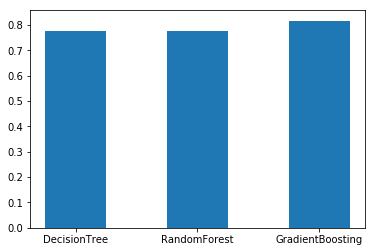

In [44]:
# Placeholder variables
sclf_val_acc=0
sclf_acc_std = 0
rfclf_val_acc = 0
rfclf_acc_std = 0
gbclf_val_acc = 0
gbclf_acc_std = 0

# Compare performance of the models
sclf_val_acc, sclf_acc_std = score(simpleclf,'DecisionTree')
rfclf_val_acc, rfclf_acc_std = score(rfclf,'RandomForest')
gbclf_val_acc, gbclf_acc_std = score(gbclf,'GradientBoosting')

# Plot
classifiers = ['DecisionTree','RandomForest','GradientBoosting']
accuracies = [sclf_val_acc, rfclf_val_acc, gbclf_val_acc]
uncertainties = [sclf_acc_std, rfclf_acc_std, gbclf_acc_std]

xtick = np.arange(len(classifiers)) # here [1,2,3]
width = 0.5

plt.bar(xtick,accuracies,width,align='center')
plt.xticks(xtick,classifiers) # Replace ticks with classifier names
plt.show()


And there you have it! From a glance, it appears that Gradient Boosting has the best overall accuracy, whereas Random Forests and regular Decision Trees are pretty neck-and-neck. However, none of these accuracies are very high. This can be attributed to insufficient amount or appropriateness of data, as well as overfitting. Some approaches such as reduced error pruning aim to reduce overfitting by removing nodes in a decision tree which have no effect on the overall accuracy of the data. This may improve the performance a little, but ultimately it is better to use deep learning to help us solve such problems. Hopefully no analysis on any future Titanics ever has to happen.

I'll never let go, Jack!